In [18]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import xgboost as xgb
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

### Loading data

In [19]:
train_data = pd.read_csv("C:/Users/johne/Downloads/playground-series-s4e7/train.csv")
test_data = pd.read_csv("C:/Users/johne/Downloads/playground-series-s4e7/test.csv")

# Display the first few rows of each dataframe
print(train_data.head())
print(test_data.head())

   id  Gender  Age  Driving_License  Region_Code  Previously_Insured  \
0   0    Male   21                1         35.0                   0   
1   1    Male   43                1         28.0                   0   
2   2  Female   25                1         14.0                   1   
3   3  Female   35                1          1.0                   0   
4   4  Female   36                1         15.0                   1   

  Vehicle_Age Vehicle_Damage  Annual_Premium  Policy_Sales_Channel  Vintage  \
0    1-2 Year            Yes         65101.0                 124.0      187   
1   > 2 Years            Yes         58911.0                  26.0      288   
2    < 1 Year             No         38043.0                 152.0      254   
3    1-2 Year            Yes          2630.0                 156.0       76   
4    1-2 Year             No         31951.0                 152.0      294   

   Response  
0         0  
1         1  
2         0  
3         0  
4         0  
        

In [20]:
# Split features and target
X = train_data.drop(['Response', 'id'], axis=1)
y = train_data['Response']
test_ids = test_data['id']
X_test = test_data.drop(['id'], axis=1)

# Identify numerical and categorical columns
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include=['object']).columns

### Preprocessing

In [21]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_cols),
        ('cat', categorical_transformer, cat_cols)
    ])

### Defining the model

In [22]:
# Define the model
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])

# Split data for validation
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


### Training Model

In [23]:
# Train the model
model.fit(X_train, y_train)

# Predict on validation set and evaluate
y_valid_pred = model.predict_proba(X_valid)[:, 1]
roc_auc = roc_auc_score(y_valid, y_valid_pred)
print(f'Validation ROC AUC: {roc_auc}')

c:\Users\johne\AppData\Local\Programs\Python\Python312\Lib\site-packages\xgboost\core.py:158: UserWarning: [15:14:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation ROC AUC: 0.8782425125130968


In [24]:
# Feature Importance
xgb_model = model.named_steps['classifier']
feature_importances = xgb_model.feature_importances_
features = num_cols.tolist() + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(cat_cols))
importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)


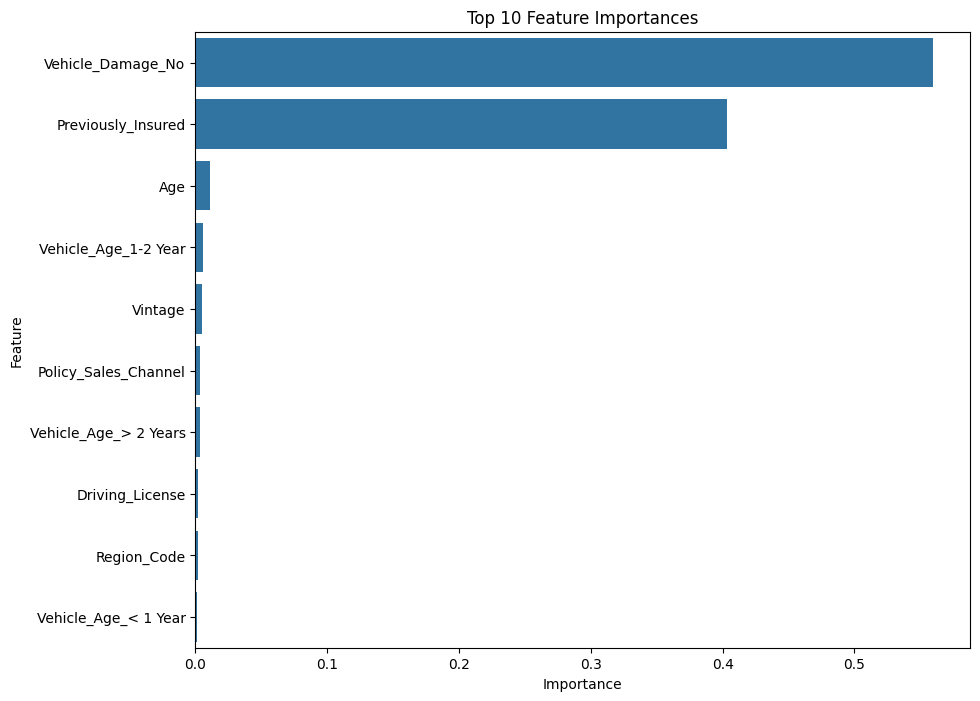

In [25]:

# Plot Feature Importance
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [26]:
# Hyperparameter Tuning
param_grid = {
    'classifier__n_estimators': [100, 200],
    'classifier__max_depth': [3, 4, 5],
    'classifier__learning_rate': [0.01, 0.05, 0.1],
    'classifier__subsample': [0.8, 1]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
print(f'Best parameters: {grid_search.best_params_}')
print(f'Best cross-validation ROC AUC: {grid_search.best_score_}')

# Error Analysis
y_valid_pred_labels = model.predict(X_valid)
print(classification_report(y_valid, y_valid_pred_labels))
conf_matrix = confusion_matrix(y_valid, y_valid_pred_labels)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Fitting 5 folds for each of 36 candidates, totalling 180 fits


In [ ]:
# Cross-Validation Score
cv_scores = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print(f'Cross-validation ROC AUC scores: {cv_scores}')
print(f'Mean cross-validation ROC AUC score: {cv_scores.mean()}')

In [ ]:
# Error Analysis
y_valid_pred_labels = model.predict(X_valid)
print(classification_report(y_valid, y_valid_pred_labels))
conf_matrix = confusion_matrix(y_valid, y_valid_pred_labels)

In [ ]:
# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No Response', 'Response'], yticklabels=['No Response', 'Response'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### Predicting and Testing

In [ ]:
# Predict on the test set
test_predictions = model.predict_proba(X_test)[:, 1]

Validation ROC AUC: 0.8782425125130968


### Submission File

In [ ]:
# Prepare the submission file
submission = pd.DataFrame({'id': test_ids, 'Response': test_predictions})
submission_path = "C:/Users/johne/Downloads/submission.csv"
submission.to_csv(submission_path, index=False)
print(f'Submission file created successfully at {submission_path}')

Submission file created successfully at C:/Users/johne/Downloads/submission.csv
